# Data Prep for Simple Classical and Quantum Classifiers

_This notebook prepares sample data for use with "Simple" classical and quantum classifiers, written in **PennyLane and PyTorch**_.

**By:** Jacob Cybulski ([website](https://jacobcybulski.com/))<br>
**Date:** 1 October 2024<br>
**Updates:** 1 October 2024<br>
**Aims:** To prepare data for the quantum and classical classifiers, to compare them.<br/>
**License:** 
This project is licensed under the [Creative Commons CC-BY](https://creativecommons.org/licenses/by/4.0/)<br>
**Changes:** All changes to this code must be listed at the bottom of this notebook

## Libraries

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/miniconda3/lib/python311.zip',
 '/home/jacob/miniconda3/lib/python3.11',
 '/home/jacob/miniconda3/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/venv/pl/lib/python3.11/site-packages',
 '.']

In [2]:
### General libraries

import os
import pylab
import math
import time
import copy
import numpy as nnp
import pandas as pd
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("warning")

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
### Import utilities
from utilities import *

## Prepare a data set

Data sets to chose from (require: pip install ucimlrepo):
- <a href="https://archive.ics.uci.edu/dataset/10/automobile" target="_blank">Automobiles</a>:
  This is a database of automobile specs. The task is to either predict the car price or determine its insurance risk (symboling).
- <a href="https://archive.ics.uci.edu/dataset/151/connectionist+bench+sonar+mines+vs+rocks" target="_blank">Sonar</a>:
  The task is to discriminate between sonar signals bounced off a mine (metal cylinder) or a rock (roughly cylindrical).<br/><br/>
  

***

<div style="font-size:24px; color:red">Data preparation objectives:</div>

- *Fetch and understand data*
- *Select numeric variables only*
- *Deal with missing values*
- *Prepare the label (change it to binary)*
- *Standardise predictors*
- *Reduce dimensionality using PCA*
- *Save PCA results in Pandas format into a file*

***
<br/>

### Files location

In [4]:
RSRC_STORE = 'rsrc'
RSRC_NAME = 'simple_auto'

### Fetch and understand data

In [5]:
from ucimlrepo import fetch_ucirepo

auto = fetch_ucirepo(id=10)

# data (as pandas dataframes) 
X_vars = auto.data.features 
y_class = auto.data.targets 
  
# metadata 
print(auto.metadata['additional_info']['summary'],'\n') 
  
# variable information 
# print(auto.variables) 

This data set consists of three types of entities: (a) the specification of an auto in terms of various characteristics, (b) its assigned insurance risk rating, (c) its normalized losses in use as compared to other cars.  The second rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price.   Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale.  Actuarians call this process "symboling".  A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.

The third factor is the relative average loss payment per insured vehicle year.  This value is normalized for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc...), and represents the average loss per car per year.

Note: Several of the attributes in the database could be used as a "class" attribute. 



In [6]:
X_vars.head(5)

,price,highway-mpg,city-mpg,peak-rpm,horsepower,compression-ratio,stroke,bore,fuel-system,engine-size,...,length,wheel-base,engine-location,drive-wheels,body-style,num-of-doors,aspiration,fuel-type,make,normalized-losses
0,13495.0,27,21,5000.0,111.0,9.0,2.68,3.47,mpfi,130,...,168.8,88.6,front,rwd,convertible,2.0,std,gas,alfa-romero,NaN
1,16500.0,27,21,5000.0,111.0,9.0,2.68,3.47,mpfi,130,...,168.8,88.6,front,rwd,convertible,2.0,std,gas,alfa-romero,NaN
2,16500.0,26,19,5000.0,154.0,9.0,3.47,2.68,mpfi,152,...,171.2,94.5,front,rwd,hatchback,2.0,std,gas,alfa-romero,NaN
3,13950.0,30,24,5500.0,102.0,10.0,3.40,3.19,mpfi,109,...,176.6,99.8,front,fwd,sedan,4.0,std,gas,audi,164.0
4,17450.0,22,18,5500.0,115.0,8.0,3.40,3.19,mpfi,136,...,176.6,99.4,front,4wd,sedan,4.0,std,gas,audi,164.0


In [7]:
# provide some stats on numeric data
X_vars.describe()

,price,highway-mpg,city-mpg,peak-rpm,horsepower,compression-ratio,stroke,bore,engine-size,num-of-cylinders,curb-weight,height,width,length,wheel-base,num-of-doors,normalized-losses
count,201.000000,205.000000,205.000000,203.000000,203.000000,205.000000,201.000000,201.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,203.000000,164.000000
mean,13207.129353,30.751220,25.219512,5125.369458,104.256158,10.142537,3.255423,3.329751,126.907317,4.380488,2555.565854,53.724878,65.907805,174.049268,98.756585,3.123153,122.000000
std,7947.066342,6.886443,6.542142,479.334560,39.714369,3.972040,0.316717,0.273539,41.642693,1.080854,520.680204,2.443522,2.145204,12.337289,6.021776,0.994841,35.442168
min,5118.000000,16.000000,13.000000,4150.000000,48.000000,7.000000,2.070000,2.540000,61.000000,2.000000,1488.000000,47.800000,60.300000,141.100000,86.600000,2.000000,65.000000
25%,7775.000000,25.000000,19.000000,4800.000000,70.000000,8.600000,3.110000,3.150000,97.000000,4.000000,2145.000000,52.000000,64.100000,166.300000,94.500000,2.000000,94.000000
50%,10295.000000,30.000000,24.000000,5200.000000,95.000000,9.000000,3.290000,3.310000,120.000000,4.000000,2414.000000,54.100000,65.500000,173.200000,97.000000,4.000000,115.000000
75%,16500.000000,34.000000,30.000000,5500.000000,116.000000,9.400000,3.410000,3.590000,141.000000,4.000000,2935.000000,55.500000,66.900000,183.100000,102.400000,4.000000,150.000000
max,45400.000000,54.000000,49.000000,6600.000000,288.000000,23.000000,4.170000,3.940000,326.000000,12.000000,4066.000000,59.800000,72.300000,208.100000,120.900000,4.000000,256.000000


### Select numeric columns only

In [8]:
# Select numeric columns only
X_sel = X_vars.select_dtypes(include=np.number)
auto_selvars = X_sel.columns
list(auto_selvars)

['price',
 'highway-mpg',
 'city-mpg',
 'peak-rpm',
 'horsepower',
 'compression-ratio',
 'stroke',
 'bore',
 'engine-size',
 'num-of-cylinders',
 'curb-weight',
 'height',
 'width',
 'length',
 'wheel-base',
 'num-of-doors',
 'normalized-losses']

### Deal with missing values

In [9]:
# Identify columns with missing values
X_sel.isna().sum().loc[lambda x : x > 0].sort_index()

bore                  4
horsepower            2
normalized-losses    41
num-of-doors          2
peak-rpm              2
price                 4
stroke                4
dtype: int64

In [10]:
# Replace all missing values with column mean
auto_xmean = X_sel.mean()
X_sel = X_sel.fillna(auto_xmean)
X_sel.isna().sum().sort_index()

bore                 0
city-mpg             0
compression-ratio    0
curb-weight          0
engine-size          0
height               0
highway-mpg          0
horsepower           0
length               0
normalized-losses    0
num-of-cylinders     0
num-of-doors         0
peak-rpm             0
price                0
stroke               0
wheel-base           0
width                0
dtype: int64

### Prepare the label

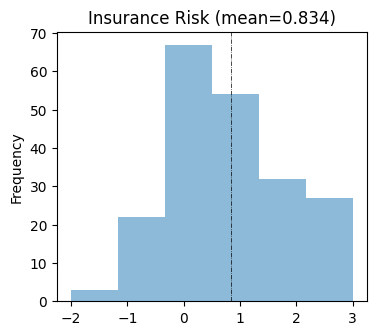

In [11]:
# Observe label distribution
auto_ymean = y_class["symboling"].mean()
ax = y_class.plot.hist(bins=6, alpha=0.5, title=f'Insurance Risk (mean={round(auto_ymean, 3)})', figsize=(4,3.5))
ax.get_legend().remove()
plt.axvline(auto_ymean, color='k', linestyle='-.', linewidth=0.5);

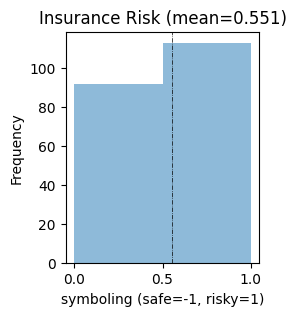

In [12]:
# Create a binary label
pd.set_option('display.max_rows', 10)
y = pd.DataFrame(y_class)
y['symboling'] = nnp.where(y['symboling'] > auto_ymean, 1, 0)
y_binmean = y["symboling"].mean()

ax = y.plot.hist(bins=2, alpha=0.5, title=f'Insurance Risk (mean={nnp.round(y_binmean, 3)})', figsize=(2.5,3))
ax.set_xlabel(f'{y.columns[0]} (safe=-1, risky=1)')
ax.get_legend().remove()
plt.axvline(y_binmean, color='k', linestyle='-.', linewidth=0.5);

### Standardise predictors

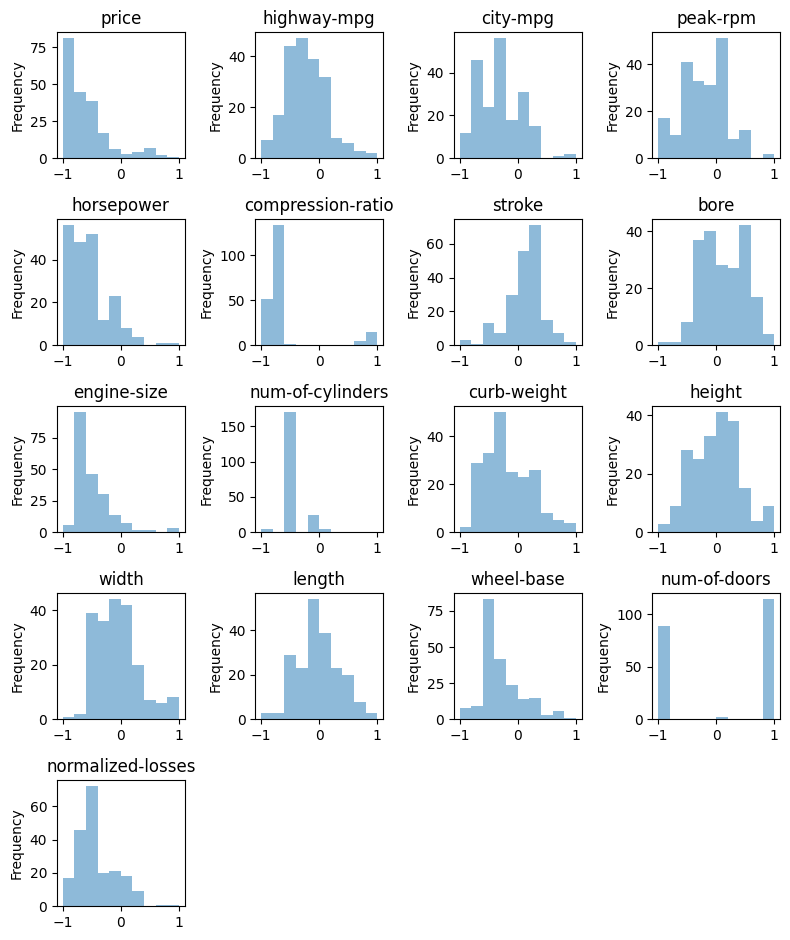

In [13]:
# Standardise all variables
from sklearn.preprocessing import StandardScaler, MinMaxScaler
auto_scaler = MinMaxScaler(feature_range=(-1, 1)) 
scaled = auto_scaler.fit_transform(X_sel) 
X_std = pd.DataFrame(scaled, columns=X_sel.columns)
multi_plot_hist(X_std, n_cols = 4, figsize=(8,9.5));

### Reduce dimensionality using PCA

In [14]:
### Reduce the number of variables using PCA
from sklearn.decomposition import PCA

n_components = 8
seed = 2024

auto_pca = PCA(n_components=n_components)
X_pca = auto_pca.fit_transform(X_std)
X_pca = pd.DataFrame(X_pca, columns=[f'PC{n:02d}' for n in range(X_pca.shape[1])])
pca_var = auto_pca.explained_variance_ratio_

In [15]:
### Sample of saved X predictors
nnp.round(X_pca[7:12], 3)

,PC00,PC01,PC02,PC03,PC04,PC05,PC06,PC07
7,1.309,-0.300,-0.380,-0.279,0.583,0.224,-0.000,-0.080
8,1.404,-0.612,-0.500,-0.491,0.684,0.113,0.094,-0.275
9,-0.650,-1.271,-0.318,-0.086,0.307,0.316,-0.018,0.097
10,-0.918,-0.757,-0.158,0.132,0.592,-0.702,0.097,-0.224
11,0.592,0.278,-0.712,-0.322,0.267,-0.821,0.115,-0.256


In [16]:
### Sample of saved y label
y[7:12]

,symboling
7,1
8,1
9,0
10,1
11,0


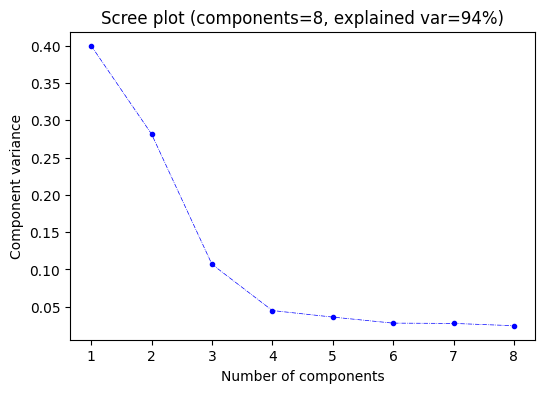

In [17]:
### Scree plot for the selected PCs
plt.figure(figsize=(6,4))
plt.plot(
    range(1,len(pca_var)+1), pca_var,
    c='blue', ls='-.', lw=0.5, marker='.')

plt.legend('', frameon=False)
plt.xlabel('Number of components')
plt.ylabel('Component variance')
plt.title(f'Scree plot (components={len(pca_var)}, explained var={int(sum(pca_var*100))}%)');

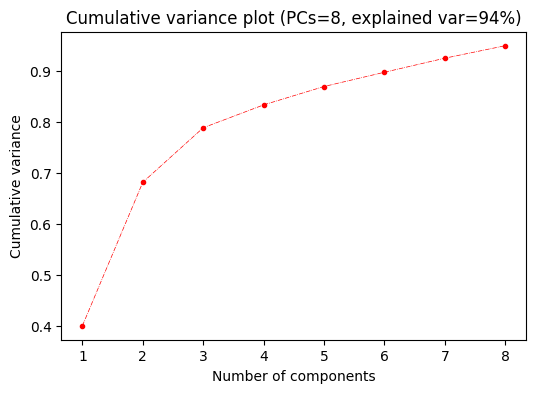

In [18]:
### Cumulative variance plot for the selected PCs
plt.figure(figsize=(6,4))
plt.plot(
    range(1,len(pca_var)+1), nnp.cumsum(pca_var),
    c='red', ls='-.', lw=0.5, marker='.')

plt.legend('', frameon=False)
plt.xlabel('Number of components')
plt.ylabel('Cumulative variance')
plt.title(f'Cumulative variance plot (PCs={len(pca_var)}, explained var={int(sum(pca_var*100))}%)');

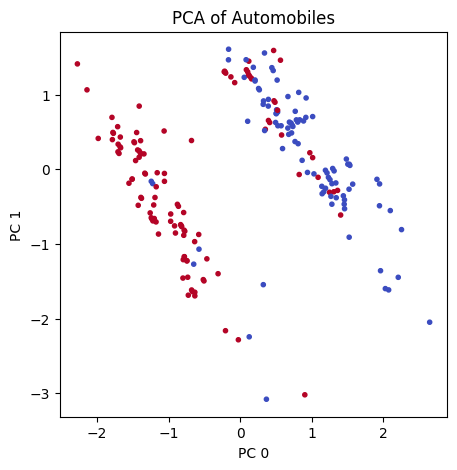

In [19]:
### Plot the two PCs
sel_pc = [0, 1]
plt.figure(figsize=(5,5))
plt.title('PCA of Automobiles')
plt.xlabel(f'PC {sel_pc[0]}')
plt.ylabel(f'PC {sel_pc[1]}')
plt.scatter(X_pca.iloc[:, sel_pc[0]],X_pca.iloc[:, sel_pc[1]], c=y['symboling'], cmap='coolwarm', marker='.');

### Save the preared data into a resource folder

In [20]:
x_file_path = os.path.join(RSRC_STORE, RSRC_NAME+'_x.pkl')
y_file_path = os.path.join(RSRC_STORE, RSRC_NAME+'_y.pkl')
X_pca.to_pickle(x_file_path)
y.to_pickle(y_file_path)
print(f'\nSaved the prepared data set:   "{RSRC_NAME}" in store "{RSRC_STORE}"')
print(f'To read the data set back use: "df = pd.read_pickle(file_path)"')


Saved the prepared data set:   "simple_auto" in store "rsrc"
To read the data set back use: "df = pd.read_pickle(file_path)"


***

<div style="font-size:24px; color:red">Other data prep tasks that could have been done:</div>
<em>Especially if we had a larger data sets</em>

- *Early partitioning of data $^{1}$*
- *Consideration of categorical variables (possibility of dummy vars)*
- *Dropping variables that have high level of missing values*
- *Dealing with variables of zero or very low IQR variance*
- *Analysis and transformation of variable skewness $^{2}$*
- *Analysis of label class imbalance $^{3}$*
- *Elimination of outliers before PCA*
- *Possible use of a robust PCA (tolerant of outliers)*
- *Analysis of PCA projections*
- *Elbow analysis of the scree plot*
- *All data transformation resources should have been archived for later use*
- *See: <a href="https://github.com/ironfrown/r-examples/tree/master/clustering" target="_blank">an example of extensive data preparation in R.</a>*

<div style="font-size:14px;">Notes:

<ol>
<li><em> Data partitioning should have been done at the very beginning. Subsequently, all transformation models (or their constants) need applied to training data and saved (here: auto_selvars, auto_xmean, auto_ymean, auto_scaler, auto_pca). Later the transformations can be applied to test data, and any new data acquired in the future. This was not done in this demo for these reasons: (1) the data set was very small, and (2) it would significantly extend the length of this demo, (3) additional data preparations are unique to the classical and quantum classification.</em></li>
    
<li><em> Skewness may or may not affect learning of neural networks - analysis of residual skewness is necessary in regression analysis, however, it may not be applicable to NNs or QNNs.</em></li>

<li><em> Note that we have implicitly performed such an analysis when reducing the label to a binary variable.</em></li>
<li><em>Spliting of data into training and testing partition has been deferred to the notebook detailing a specific model creation and further data preparation as required.</em></li>

</ul>
</div>

***

### Data preparation completed

## Modifications (do not remove)
Under the [Creative Commons CC-BY](https://creativecommons.org/licenses/by/4.0/) license, if you perform any changes to this notebook, please list them here, adding a note with your name, contact details, date and changes to the code.

- [Jacob Cybulski](http://jacobcybulski.com) (2024, 1 Oct): The author of this notebook added this section to record all code changes

## Systems in use

In [22]:
!pip list | grep -e PennyLane -e torch

PennyLane                 0.40.0
PennyLane_Lightning       0.40.0
torch                     2.6.0+cpu
torchaudio                2.6.0+cpu
torchsummary              1.5.1
torchvision               0.21.0+cpu

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
